# read data , Import libraries , load model using Api

In [89]:
import re
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from gensim.models import Word2Vec,KeyedVectors
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from tqdm import tqdm
import seaborn as sns
import gensim.downloader as api

In [3]:
df=pd.read_csv('kindle_review .csv')

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [5]:
df=df[['reviewText','rating']]

In [6]:
df.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [7]:
df['rating'].unique()

array([3, 5, 4, 2, 1], dtype=int64)

In [8]:
df['rating'].value_counts()

rating
5    3000
4    3000
3    2000
2    2000
1    2000
Name: count, dtype: int64

# Preprocessing & Cleaning

In [9]:
df['reviewText']=df['reviewText'].str.lower()

In [10]:
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', str(x)))  # إزالة الرموز غير المرغوبة
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([y for y in x.split() if y.lower() not in stopwords.words('english')]))  # إزالة الكلمات الشائعة
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(r'(https?|ftp|ssh)://[\w.-]+(?:\.[\w.-]+)+(?:[\w.,@?^=%&:/~+#-]*)?', '', str(x)))  # إزالة الروابط
df['reviewText'] = df['reviewText'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())  # إزالة الوسوم HTML
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.split()))  # إزالة المسافات الزائدة


In [11]:
df

,reviewText,rating
0,jace rankin may short hes nothing mess man hau...,3
1,great short read didnt want put read one sitti...,5
2,ill start saying first four books wasnt expect...,3
3,aggie angela lansbury carries pocketbooks inst...,3
4,expect type book library pleased find price right,4
...,...,...
11995,valentine cupid vampire jena ian another vampi...,4
11996,read seven books series apocalypticadventure o...,5
11997,book really wasnt cuppa situation man capturin...,3
11998,tried use charge kindle didnt even register ch...,1


In [12]:
lemmatizer=WordNetLemmatizer()

In [13]:
def lematization(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
df['reviewText'] = df['reviewText'].apply(lambda x: lematization(x))

In [38]:
x=df['reviewText']
y=df['rating'].apply(lambda x :0 if x <3 else 1)

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)

# Using BOW

In [47]:
bow_vec=CountVectorizer()
x_train_bow=bow_vec.fit_transform(x_train).toarray()
x_test_bow=bow_vec.transform(x_test).toarray()

## XGBoost

In [48]:
xgb_bow=XGBClassifier()

In [49]:
xgb_bow.fit(x_train_bow,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred=xgb_bow.predict(x_test_bow)

In [51]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.63      0.80      0.70       636
           1       0.92      0.83      0.87      1764

    accuracy                           0.82      2400
   macro avg       0.78      0.81      0.79      2400
weighted avg       0.84      0.82      0.83      2400



<Axes: >

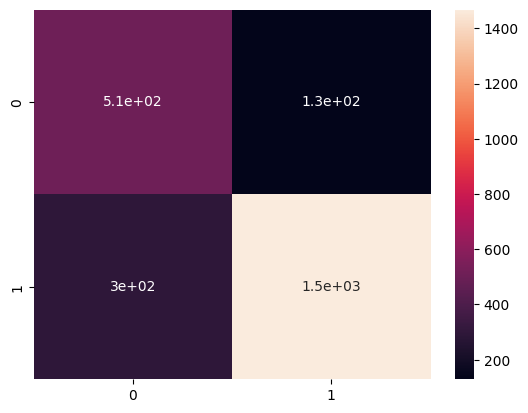

In [57]:
sns.heatmap(confusion_matrix(xgb_bow.predict(x_test_bow),y_test),annot=True)

## Naive Bay's

In [53]:
nb_bow=GaussianNB().fit(x_train_bow,y_train)

In [54]:
print(classification_report(nb_bow.predict(x_test_bow),y_test))

              precision    recall  f1-score   support

           0       0.62      0.41      0.50      1210
           1       0.56      0.75      0.64      1190

    accuracy                           0.58      2400
   macro avg       0.59      0.58      0.57      2400
weighted avg       0.59      0.58      0.57      2400



<Axes: >

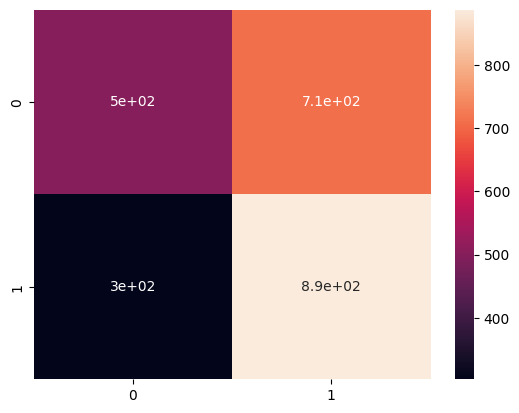

In [58]:
sns.heatmap(confusion_matrix(nb_bow.predict(x_test_bow),y_test),annot=True)

# Using TF-IDF

In [59]:
tf_idf=TfidfVectorizer()
x_train_tf=tf_idf.fit_transform(x_train).toarray()
x_test_tf=tf_idf.transform(x_test).toarray()

## XGBoost

In [60]:
xgb_tf=XGBClassifier()

In [61]:
xgb_tf.fit(x_train_tf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
y_pred=xgb_tf.predict(x_test_tf)

In [63]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       643
           1       0.91      0.83      0.87      1757

    accuracy                           0.81      2400
   macro avg       0.77      0.80      0.78      2400
weighted avg       0.83      0.81      0.82      2400



<Axes: >

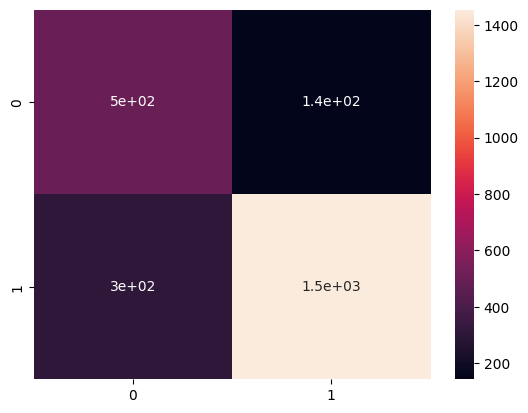

In [64]:
sns.heatmap(confusion_matrix(xgb_tf.predict(x_test_tf),y_test),annot=True)

## Naive Bay's

In [65]:
nb_tf=GaussianNB().fit(x_train_tf,y_train)

In [66]:
print(classification_report(nb_tf.predict(x_test_tf),y_test))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49      1173
           1       0.57      0.74      0.64      1227

    accuracy                           0.58      2400
   macro avg       0.58      0.58      0.57      2400
weighted avg       0.58      0.58      0.57      2400



<Axes: >

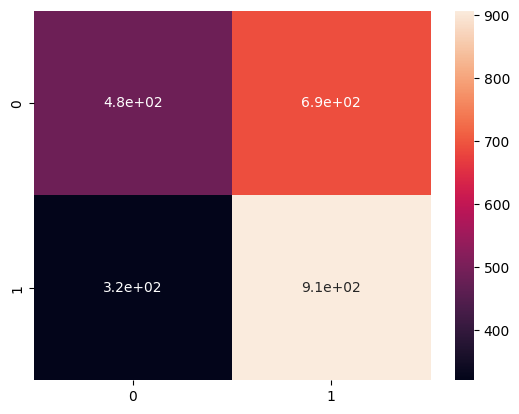

In [67]:
sns.heatmap(confusion_matrix(nb_tf.predict(x_test_tf),y_test),annot=True)

# Word2Vec & Avg Word2Vec

In [69]:
w2v=api.load('word2vec-google-news-300')

In [74]:
words=[]
for sent in x:
    sent_token=sent_tokenize(sent)
    for sent in sent_token:
        words.append(simple_preprocess(sent))

In [79]:
model=Word2Vec(words,vector_size=200)

In [81]:
model.wv.index_to_key

['book',
 'story',
 'read',
 'one',
 'character',
 'like',
 'good',
 'would',
 'really',
 'love',
 'time',
 'get',
 'author',
 'reading',
 'series',
 'much',
 'first',
 'well',
 'even',
 'didnt',
 'short',
 'know',
 'way',
 'could',
 'great',
 'make',
 'sex',
 'little',
 'dont',
 'thing',
 'want',
 'two',
 'think',
 'find',
 'plot',
 'also',
 'romance',
 'end',
 'life',
 'im',
 'see',
 'enjoyed',
 'go',
 'scene',
 'never',
 'take',
 'woman',
 'many',
 'lot',
 'written',
 'kindle',
 'say',
 'work',
 'thought',
 'bit',
 'found',
 'year',
 'going',
 'give',
 'interesting',
 'liked',
 'writing',
 'novel',
 'loved',
 'another',
 'feel',
 'better',
 'got',
 'come',
 'man',
 'hot',
 'still',
 'enough',
 'back',
 'though',
 'people',
 'reader',
 'made',
 'star',
 'review',
 'something',
 'part',
 'friend',
 'cant',
 'page',
 'need',
 'bad',
 'keep',
 'new',
 'wasnt',
 'free',
 'world',
 'doesnt',
 'relationship',
 'enjoy',
 'recommend',
 'together',
 'next',
 'start',
 'felt',
 'best',
 'put',

In [86]:
def avg_w2v(doc):
    vectors = [model.wv[word] for word in doc if word in model.wv.index_to_key]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [87]:
x_w2v=[]
for i in tqdm(range(len(words))):
    x_w2v.append(avg_w2v(words[i]))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [01:27<00:00, 137.49it/s]


In [88]:
x_w2v

[array([ 0.11270685, -0.0149746 ,  0.08407543,  0.20328468,  0.24723187,
        -0.09928039, -0.02005675,  0.34552217, -0.1807476 ,  0.22573063,
        -0.01673212, -0.3363085 ,  0.00119495,  0.06848858,  0.0761359 ,
        -0.00924981, -0.23358715, -0.04882841,  0.04602011, -0.3568966 ,
         0.12339103, -0.2050363 ,  0.03723202,  0.01647585, -0.0266192 ,
        -0.00704048,  0.04235279, -0.20566016, -0.1202496 ,  0.18686071,
         0.25298154,  0.05518274,  0.12080555,  0.14930618, -0.00465757,
         0.265852  ,  0.08968576, -0.09134807, -0.11887187, -0.2953142 ,
        -0.20198584,  0.0397421 , -0.00616737,  0.15933515,  0.33366394,
         0.02434494, -0.12133788, -0.19491355,  0.11172186,  0.17485037,
         0.18135011,  0.01174476, -0.14216179, -0.16692784,  0.00989748,
        -0.03170359, -0.03814641, -0.1769165 , -0.22156861,  0.10061461,
        -0.00900441,  0.09232318,  0.00699244, -0.02709163, -0.27928138,
        -0.04781033, -0.01633336,  0.38040832, -0.2

In [90]:
x_w2v=np.array(x_w2v)

In [91]:
df=pd.DataFrame(np.vstack(x_w2v))

In [92]:
df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.112707,-0.014975,0.084075,0.203285,0.247232,-0.099280,-0.020057,0.345522,-0.180748,0.225731,...,0.166517,-0.101502,-0.167767,-0.197519,0.194553,0.092682,0.054731,-0.257960,0.014985,-0.169659
1,0.126827,-0.157414,-0.139326,0.209739,0.366961,-0.066486,0.198731,0.477636,-0.170676,0.123489,...,0.220055,0.074181,-0.417823,-0.374646,0.256801,0.284284,0.191334,-0.368668,0.180898,-0.334970
2,0.016544,-0.036723,-0.072514,0.179659,0.321060,-0.120678,0.064334,0.484230,-0.108967,0.163006,...,0.166611,0.015188,-0.133161,-0.247107,0.243154,0.158160,0.148616,-0.298864,0.055224,-0.236345
3,-0.116422,0.043929,-0.102624,0.118396,0.374820,0.062002,0.171874,0.387611,-0.145526,0.217084,...,0.206460,0.070901,-0.079938,-0.259515,0.256781,0.087453,0.192243,-0.314083,0.114845,-0.210250
4,0.094702,-0.060654,-0.081121,0.133980,0.269830,-0.199264,-0.069922,0.546535,0.015276,0.025702,...,0.301870,0.168071,-0.279826,-0.354678,0.216548,0.305385,0.144534,-0.302880,-0.167509,-0.079344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.174946,-0.090245,0.140657,0.053517,0.117826,-0.221790,-0.067057,0.427120,-0.464074,0.050255,...,0.142889,-0.165892,0.008527,-0.094312,0.244741,0.037392,0.010454,-0.352535,-0.104692,-0.152333
11996,0.041883,-0.097124,-0.139658,0.043443,0.286671,-0.063658,0.159068,0.505646,-0.091979,0.011865,...,0.271687,0.169010,-0.195661,-0.350778,0.346558,0.185033,0.263147,-0.307785,-0.061989,-0.191888
11997,0.205735,-0.051328,-0.005857,0.273744,0.334059,-0.077699,0.193319,0.379911,-0.105179,0.226771,...,0.129951,0.028049,-0.311612,-0.205477,0.233533,0.256214,0.148753,-0.372771,0.160619,-0.203536
11998,0.036235,0.014221,0.027104,0.318369,0.192753,-0.085893,-0.184689,0.292760,0.071831,0.202264,...,0.204811,-0.123283,-0.247038,-0.293964,0.053088,0.141942,0.068189,-0.107034,-0.123813,-0.158680


In [93]:
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=.2,random_state=42)

## XGBoost

In [94]:
xgb_w2v=XGBClassifier()

In [96]:
xgb_w2v.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [100]:
y_pred=xgb_w2v.predict(x_test)

In [101]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       694
           1       0.86      0.81      0.83      1706

    accuracy                           0.77      2400
   macro avg       0.72      0.74      0.73      2400
weighted avg       0.78      0.77      0.77      2400



<Axes: >

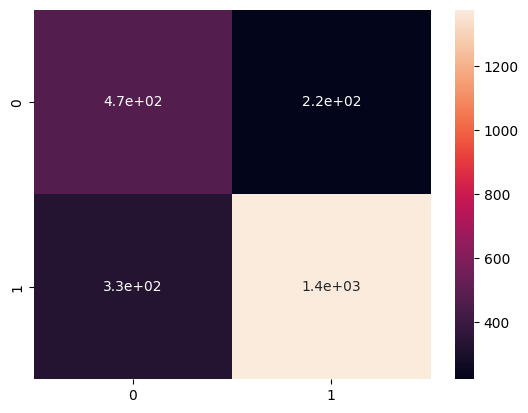

In [103]:
sns.heatmap(confusion_matrix(xgb_w2v.predict(x_test),y_test),annot=True)

## Naive Bay's

In [104]:
nb_w2v=GaussianNB().fit(x_train,y_train)

In [105]:
print(classification_report(nb_w2v.predict(x_test),y_test))

              precision    recall  f1-score   support

           0       0.76      0.56      0.64      1089
           1       0.70      0.85      0.77      1311

    accuracy                           0.72      2400
   macro avg       0.73      0.71      0.71      2400
weighted avg       0.73      0.72      0.71      2400



<Axes: >

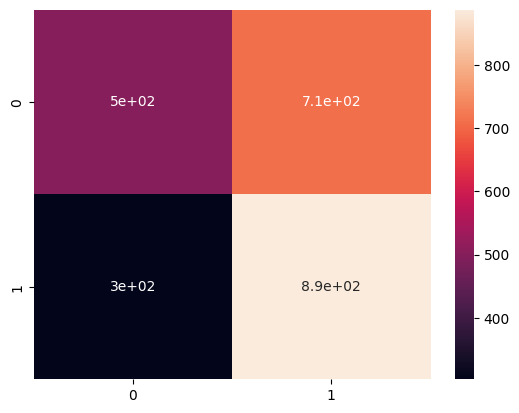

In [106]:
sns.heatmap(confusion_matrix(nb_bow.predict(x_test_bow),y_test),annot=True)